# 初始化环境

初始化环境会做以下几件事情：

1. 获取当前 region_name/account_id/role 等信息
2. 设置 inference endpoint 的容器镜像版本，变量 VERSION
3. 写一个 get_bucket_and_key 函数用来解析 bucket 和 key

In [41]:
import sagemaker
import json
import io
from PIL import Image
import boto3

# ECR 中容器镜像的版本
VERSION = "latest"

# 获取 Sagemaker 执行的环境，包括它的默认 buck
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

account_id = boto3.client('sts').get_caller_identity().get('Account')
region_name = boto3.session.Session().region_name

s3_resource = boto3.resource('s3')

def get_bucket_and_key(s3uri):
    pos = s3uri.find('/', 5)
    bucket = s3uri[5 : pos]
    key = s3uri[pos + 1 : ]
    return bucket, key

print("account_id:", account_id)
print("region_name:", region_name)

account_id: 525558421402
region_name: us-east-1


## 创建模型

1. 这里的模型指的是 Sagemaker Inference Model，在后面用于创建 Endpoint
2. 这里会实例化一个 model，主要设置了两个参数：
    1. model_data：之前打包上传的 model.tar.gz 文件（参考 README.md）
    2. image_uri：之前 build push 到 ECR 的用于 Inference 的容器镜像
3. 此时只会实例化一个 model，不会在

In [42]:
from sagemaker.model import Model
from sagemaker.predictor import Predictor

model_environment = {
    'SAGEMAKER_MODEL_SERVER_TIMEOUT': '1200',
    'ckpt': '/opt/ml/model/Stable-diffusion/rpg.safetensors'
}

model = Model(
    name="FunClubModel",
    model_data="s3://array-platform-aigc/models/six_in_one_model.tar.gz", # 打包的三个目录：Stable-diffusion、Lora、ControlNet
    role=sagemaker.get_execution_role(),
    image_uri=f'525558421402.dkr.ecr.us-east-1.amazonaws.com/array-sd-inference:{VERSION}', # ECR 的镜像地址
    env=model_environment,
    predictor_cls=Predictor
)

## Create Endpoint config

In [43]:
from sagemaker.async_inference import AsyncInferenceConfig
instance_type = 'ml.g5.2xlarge'
instance_count = 1
outputs = "s3://slack-bot-aigc-images/outputs/"
async_config = AsyncInferenceConfig(output_path=outputs,)

## Deploy Endpoint

In [ ]:
predictor = model.deploy(
    endpoint_name=f"FunClub-{VERSION}",
    instance_type=instance_type, 
    initial_instance_count=instance_count,
    async_inference_config=async_config
)

Using already existing model: FunClubModel


------

In [ ]:
print(predictor)

## Test Endpoint inference and lora

In [30]:
predictor = Predictor(endpoint_name="FunClub")

In [29]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()

inputs = {
    'task': 'text-to-image', 
    'model': 'rpg.safetensors',
    'txt2img_payload': {
        'enable_hr': False, 
        'denoising_strength': 0.7, 
        'firstphase_width': 0, 
        'firstphase_height': 0, 
        'prompt': 'beautiful (swedish:1.3) , Full body armor made of demon (demon armor:1.3), 1 man, (insanely detailed:1.5), light particle, (mist on the floor:1.3), ((solo)), (highest quality, Alessandro Casagrande, Greg Rutkowski, Sally Mann, concept art, 4k), (colorful), (high sharpness), ((detailed pupils)), red eyes, ((painting:1.1)), (digital painting:1.1), detailed face and eyes,Masterpiece, best quality, highly detailed photo:1, 8k, detailed face,photorealistic, dark and gloomy, fog, thunder background, By jeremy mann, by sandra chevrier, by maciej kuciara,((male demon)), sharp, ((perfect body)), realistic, real shadow, 3d, ((squatting warrior)), ((dark and gloomy castle background:1.3)), thunder sky, thunder, (by Michelangelo), king pose:1,1, side view:1,1', 
        'negative_prompt': '(bad art, low detail, pencil drawing:1.6), (plain background, grainy, low quality, mutated hands and fingers:1.5), (watermark, thin lines:1.3), (deformed, signature:1.2), (big nipples, blurry, ugly, bad anatomy, extra limbs, undersaturated, low resolution), disfigured, deformations, out of frame, amputee, bad proportions, extra limb, missing limbs, distortion, floating limbs, out of frame, poorly drawn face, poorly drawn hands, text, malformed, error, missing fingers, cropped, jpeg artifacts, teeth, unsharp', 
        'styles': ['None', 'None'], 
        'seed': -1.0, 
        'subseed': -1.0, 
        'subseed_strength': 0, 
        'seed_resize_from_h': 0, 
        'seed_resize_from_w': 0, 
        'sampler_index': 'DPM++ 2S a Karras', 
        'batch_size': 1, 
        'n_iter': 1, 
        'steps': 35, 
        'cfg_scale': 7, 
        'width': 512, 
        'height': 512, 
        'restore_faces': True, 
        'tiling': False, 
        'eta': 1, 
        's_churn': 0, 
        's_tmax': None, 
        's_tmin': 0, 
        's_noise': 1, 
        'override_settings': {}, 
        'script_args': [0, False, False, False, "", 1, "", 0, "", True, False, False]}
}

prediction = predictor.predict_async(inputs)

from sagemaker.async_inference.waiter_config import WaiterConfig
print(f"Response output path: {prediction.output_path}")
print("Start Polling to get response:")

import time

start = time.time()

config = WaiterConfig(
  max_attempts=100, #  number of attempts
  delay=10 #  time in seconds to wait between attempts
  )

prediction.get_result(config)

print(f"Time taken: {time.time() - start}s")
print("Inference finished")

AttributeError: 'Predictor' object has no attribute 'predict_async'

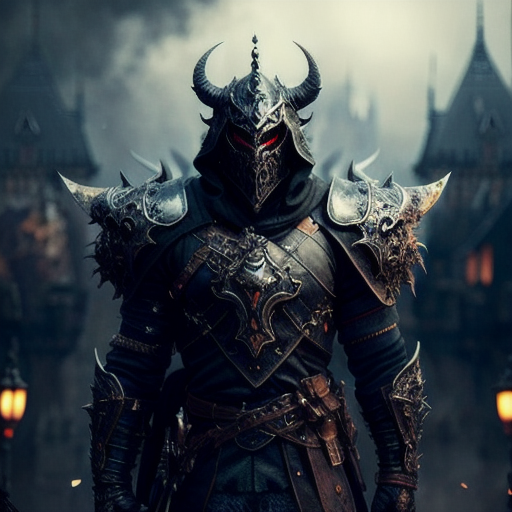

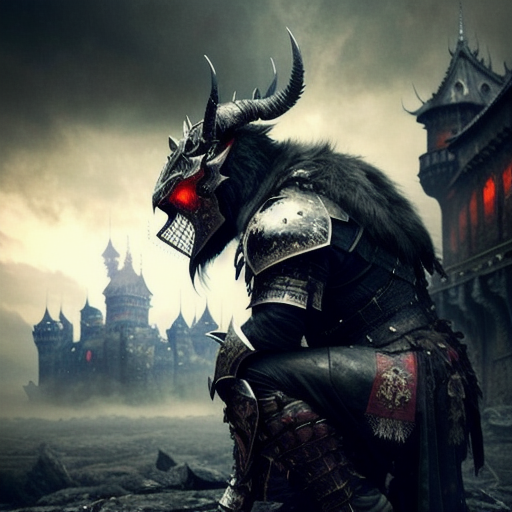

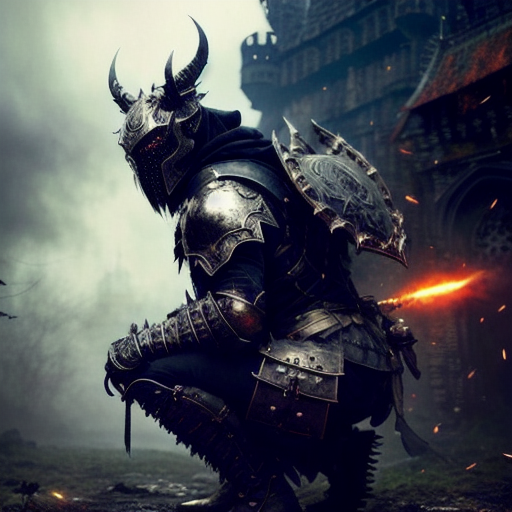

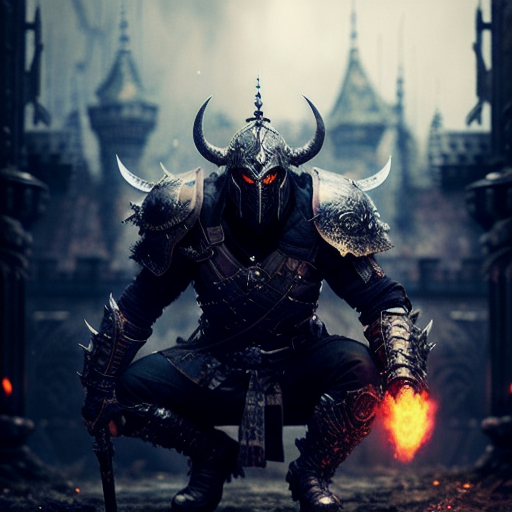

In [17]:
import traceback
from PIL import Image
import base64
from datetime import datetime
try:
    bucket, key = get_bucket_and_key(prediction.output_path)
    obj = s3_resource.Object(bucket, key)
    body = obj.get()['Body'].read().decode('utf-8') 
    for image in json.loads(body)['images']:
        image = Image.open(io.BytesIO(base64.b64decode(image)))
        display(image)
except Exception as e:
    traceback.print_exc()
    print(e)

## Update Endpoint

In [ ]:
predictor = Predictor(endpoint_name="SixInOne")
predictor.update_endpoint(instance_type="ml.g4dn.2xlarge", initial_instance_count=1)

## Delete Endpoint

In [ ]:
#model.delete_model()
#predictor.delete_endpoint()